# Step 3: Model Building

Using the labeled feature data set constructed in the `Code/2_feature_engineering.ipynb` Jupyter notebook, this notebook loads the data from the Azure Blob container and splits it into a training and test data set. We then build a machine learning model (a decision tree classifier or a random forest classifier) to predict when different components within our machine population will fail. We store the better performing model for deployment in an Azure web service in the next. We will prepare and build the web service in the `Code/4_operationalization.ipynb` Jupyter notebook.

**Note:** This notebook will take about 2-4 minutes to execute all cells, depending on the compute configuration you have setup. 

In [8]:
# import the libraries
import os
import glob
import time

# for creating pipelines and model
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.sql.functions import col
from pyspark.sql import SparkSession

#for features importance ploting

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# For some data handling
import pandas as pd
import numpy as np
# For Azure blob storage access
from azure.storage.blob import BlockBlobService
from azure.storage.blob import PublicAccess

# For logging model evaluation parameters back into the
# AML Workbench run history plots.
import logging
from azureml.logging import get_azureml_logger

amllog = logging.getLogger("azureml")
amllog.level = logging.INFO

# Turn on cell level logging.
%azureml history on
%azureml history show

# Time the notebook execution. 
# This will only make sense if you "Run all cells"
tic = time.time()

logger = get_azureml_logger() # logger writes to AMLWorkbench runtime view
spark = SparkSession.builder.getOrCreate()

# Telemetry
logger.log('amlrealworld.predictivemaintenance.feature_engineering','true')

History logging enabled
History logging is enabled


# Load feature data set

We have previously created the labeled feature data set in the `Code\2_feature_engineering.ipynb` Jupyter notebook. Since the Azure Blob storage account name and account key are not passed between notebooks, you'll need your credentials here again.

In [9]:
# Enter your Azure blob storage details here 
ACCOUNT_NAME = ""

# You can find the account key under the _Access Keys_ link in the 
# [Azure Portal](portal.azure.com) page for your Azure storage container.
ACCOUNT_KEY = ""

#-------------------------------------------------------------------------------------------
# The data from the feature engineering note book is stored in the feature engineering container.
CONTAINER_NAME = CONTAINER_NAME = ""

# Connect to your blob service     
az_blob_service = BlockBlobService(account_name=ACCOUNT_NAME, account_key=ACCOUNT_KEY)

# We will store and read each of these data sets in blob storage in an 
# Azure Storage Container on your Azure subscription.
# See https://github.com/Azure/ViennaDocs/blob/master/Documentation/UsingBlobForStorage.md
# for details.

# This is the final feature data file.
FEATURES_LOCAL_DIRECT = 'featureengineering_files.parquet'

# This is where we store the final model data file.
LOCAL_DIRECT = 'model_result.parquet'

Load the data and dump a short summary of the resulting DataFrame.

In [10]:
# load the previous created final dataset into the workspace
# create a local path where we store results
if not os.path.exists(FEATURES_LOCAL_DIRECT):
    os.makedirs(FEATURES_LOCAL_DIRECT)
    print('DONE creating a local directory!')

# download the entire parquet result folder to local path for a new run 
for blob in az_blob_service.list_blobs(CONTAINER_NAME):
    if FEATURES_LOCAL_DIRECT in blob.name:
        local_file = os.path.join(FEATURES_LOCAL_DIRECT, os.path.basename(blob.name))
        az_blob_service.get_blob_to_path(CONTAINER_NAME, blob.name, local_file)

feat_data = spark.read.parquet(FEATURES_LOCAL_DIRECT)
feat_data.limit(10).toPandas().head(10)

,machineID,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label_e
0,27,2016-01-01 12:00:00,162.374561,445.713044,103.468532,39.696107,166.697820,444.924308,100.427843,40.302193,...,0.0,504.0,564.0,444.0,399.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
1,27,2016-01-01 00:00:00,169.634236,448.824824,100.134285,40.534216,168.831580,455.688535,98.841978,39.876219,...,0.0,504.0,564.0,444.0,399.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
2,27,2015-12-31 12:00:00,168.028923,462.552245,97.549672,39.218223,165.477871,454.466625,98.704752,39.480803,...,0.0,503.0,563.0,443.0,398.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
3,27,2015-12-31 00:00:00,162.926820,446.381005,99.859832,39.743383,163.461431,447.678924,101.114095,39.132162,...,0.0,503.0,563.0,443.0,398.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
4,27,2015-12-30 12:00:00,163.996042,448.976843,102.368357,38.520940,167.565612,448.850939,98.799875,38.876751,...,0.0,502.0,562.0,442.0,397.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
5,27,2015-12-30 00:00:00,171.135183,448.725035,95.231392,39.232562,171.374485,444.711628,97.554254,40.444985,...,0.0,502.0,562.0,442.0,397.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
6,27,2015-12-29 12:00:00,171.613787,440.698222,99.877115,41.657408,171.004827,436.349482,101.844735,40.585287,...,0.0,501.0,561.0,441.0,396.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
7,27,2015-12-29 00:00:00,170.395866,432.000742,103.812354,39.513166,172.140074,440.871262,102.942478,39.409219,...,0.0,501.0,561.0,441.0,396.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
8,27,2015-12-28 12:00:00,173.884282,449.741783,102.072602,39.305273,170.610373,448.210517,100.055028,39.664584,...,0.0,500.0,560.0,440.0,395.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0
9,27,2015-12-28 00:00:00,167.336463,446.679251,98.037455,40.023895,164.276595,448.119379,101.525568,40.340740,...,0.0,500.0,560.0,440.0,395.0,model2,9,"(0.0, 0.0, 1.0)",0.0,0.0


In [11]:
type(feat_data)

pyspark.sql.dataframe.DataFrame

# Prepare the Training/Testing data

A fundamental practice in machine learning is to calibrate and test your model parameters on data that has not been used to train the model. Evaluation of the model requires splitting the available data into a training portion, a calibration portion and an evaluation portion. Typically, 80% of data is used to train the model and 10% each to calibrate any parameter selection and evaluate your model.

In general random splitting can be used, but since time series data have an inherent correlation between observations. For predictive maintenance problems, a time-dependent spliting strategy is often a better approach to estimate performance. For a time-dependent split, a single point in time is chosen, the model is trained on examples up to that point in time, and validated on the examples after that point. This simulates training on current data and score data collected in the future data after the splitting point is not known. However, care must be taken on labels near the split point. In this case, feature records within 7 days of the split point can not be labeled as a failure, since that is unobserved data. 

In the following code blocks, we split the data at a single point to train and evaluate this model. 

In [12]:
# define list of input columns for downstream modeling

# We'll use the known label, and key variables.
label_var = ['label_e']
key_cols =['machineID','dt_truncated']

# Then get the remaing feature names from the data
input_features = feat_data.columns

# We'll use the known label, key variables and 
# a few extra columns we won't need.
remove_names = label_var + key_cols + ['failure','model_encoded','model' ]

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_names)]

input_features

['volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'vibration_rollingmean_24',
 'volt_rollingmean_36',
 'vibration_rollingmean_36',
 'rotate_rollingmean_36',
 'pressure_rollingmean_36',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'volt_rollingstd_36',
 'rotate_rollingstd_36',
 'pressure_rollingstd_36',
 'vibration_rollingstd_36',
 'error1sum_rollingmean_24',
 'error2sum_rollingmean_24',
 'error3sum_rollingmean_24',
 'error4sum_rollingmean_24',
 'error5sum_rollingmean_24',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'age']

Spark models require a vectorized data frame. We transform the dataset here and then split the data into a training and test set. We use this split data to train the model on 9 months of data (training data), and evaluate on the remaining 3 months (test data) going forward.

In [13]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label_e','features')

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label_e", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

print(training.count())
print(testing.count())

603000
128000


# Classification models

A particualar troubling behavior in predictive maintenance is machine failures are usually rare occurrences compared to normal operation. This is fortunate for the business as maintenance and saftey issues are few, but causes an imbalance in the label distribution. This imbalance leads to poor performance as algorithms tend to classify majority class examples at the expense of minority class, since the total misclassification error is much improved when majority class is labeled correctly. This causes low recall or precision rates, although accuracy can be high. It becomes a larger problem when the cost of false alarms is very high. To help with this problem, sampling techniques such as oversampling of the minority examples can be used. These methods are not covered in this notebook. Because of this, it is also important to look at evaluation metrics other than accuracy alone.

We will build and compare two different classification model approaches:

 - **Decision Tree Classifier**: Decision trees and their ensembles are popular methods for the machine learning tasks of classification and regression. Decision trees are widely used since they are easy to interpret, handle categorical features, extend to the multiclass classification setting, do not require feature scaling, and are able to capture non-linearities and feature interactions.

 - **Random Forest Classifier**: A random forest is an ensemble of decision trees. Random forests combine many decision trees in order to reduce the risk of overfitting. Tree ensemble algorithms such as random forests and boosting are among the top performers for classification and regression tasks.

We will to compare these models in the AML Workbench _runs_ screen. The next code block creates the model. You can choose between a _DecisionTree_ or _RandomForest_ by setting the 'model_type' variable. We have also included a series of model hyperparameters to guide your exploration of the model space.

In [16]:
model_type = 'RandomForest' # Use 'DecisionTree', or 'RandomForest'

# train a model.
if model_type == 'DecisionTree':
    model = DecisionTreeClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures",
                                      # Maximum depth of the tree. (>= 0) 
                                      # E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'
                                      maxDepth=15,
                                      # Max number of bins for discretizing continuous features. 
                                      # Must be >=2 and >= number of categories for any categorical feature.
                                      maxBins=32, 
                                      # Minimum number of instances each child must have after split. 
                                      # If a split causes the left or right child to have fewer than 
                                      # minInstancesPerNode, the split will be discarded as invalid. Should be >= 1.
                                      minInstancesPerNode=1, 
                                      # Minimum information gain for a split to be considered at a tree node.
                                      minInfoGain=0.0, 
                                      # Criterion used for information gain calculation (case-insensitive). 
                                      # Supported options: entropy, gini')
                                      impurity="gini")

    ##=======================================================================================================================
    #elif model_type == 'GBTClassifier':
    #    cls_mthd = GBTClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures")
    ##=======================================================================================================================
else:    
    model = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", 
                                      # Passed to DecisionTreeClassifier
                                      maxDepth=15, 
                                      maxBins=32, 
                                      minInstancesPerNode=1, 
                                      minInfoGain=0.0,
                                      impurity="gini",
                                      # Number of trees to train (>= 1)
                                      numTrees=50, 
                                      # The number of features to consider for splits at each tree node. 
                                      # Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].
                                      featureSubsetStrategy="sqrt", 
                                      # Fraction of the training data used for learning each 
                                      # decision tree, in range (0, 1].' 
                                      subsamplingRate = 0.632)

# chain indexers and model in a Pipeline
pipeline_cls_mthd = Pipeline(stages=[labelIndexer, featureIndexer, model])

# train model.  This also runs the indexers.
model_pipeline = pipeline_cls_mthd.fit(training)


To evaluate this model, we predict the component failures over the test data set. Since the test set has been created from data the model has not been seen before, it simulates future data. The evaluation then can be generalize to how the model could perform when operationalized and used to score the data in real time.

In [17]:
# make predictions. The Pipeline does all the same operations on the test data
predictions = model_pipeline.transform(testing)

# Create the confusion matrix for the multiclass prediction results
# This result assumes a decision boundary of p = 0.5
conf_table = predictions.stat.crosstab('indexedLabel', 'prediction')
confuse = conf_table.toPandas()
confuse.head()

,indexedLabel_prediction,0.0,1.0,2.0,3.0,4.0
0,0.0,119604,12,13,16,3
1,1.0,2388,821,5,0,0
2,2.0,1782,2,626,0,0
3,3.0,1083,0,1,398,0
4,4.0,930,1,0,0,315


The confusion matrix lists each true component failure in rows and the predicted value in columns. Labels numbered 0.0 corresponds to no component failures. Labels numbered 1.0 through 4.0 correspond to failures in one of the four components in the machine. As an example, the third number in the top row indicates how many days we predicted component 2 would fail, when no components actually did fail. The second number in the second row, indicates how many days we correctly predicted a component 1 failure within the next 7 days.

We read the confusion matrix numbers along the diagonal as correctly classifying the component failures. Numbers above the diagonal indicate the model incorrectly predicting a failure when non occured, and those below indicate incorrectly predicting a non-failure for the row indicated component failure.

When evaluating classification models, it is convenient to reduce the results in the confusion matrix into a single performance statistic. However, depending on the problem space, it is impossible to always use the same statistic in this evaluation. Below, we calculate four such statistics.

- **Accuracy**: reports how often we correctly predicted the labeled data. Unfortunatly, when there is a class imbalance (a large number of one of the labels relative to others), this measure is biased towards the largest class. In this case non-failure days.

Because of the class imbalance inherint in predictive maintenance problems, it is better to look at the remaining statistics instead. Here positive predictions indicate a failure.

- **Precision**: Precision is a measure of how well the model classifies the truely positive samples. Precision depends on falsely classifying negative days as positive.

- **Recall**: Recall is a measure of how well the model can find the positive samples. Recall depends on falsely classifying positive days as negative.

- **F1**: F1 considers both the precision and the recall. F1 score is the harmonic average of precision and recall. An F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0.

These metrics make the most sense for binary classifiers, though they are still useful for comparision in our multiclass setting. Below we calculate these evaluation statistics for the selected classifier, and post them back to the AML workbench run time page for tracking between experiments.

In [18]:
# select (prediction, true label) and compute test error
# select (prediction, true label) and compute test error
# True positives - diagonal failure terms 
tp = confuse['1.0'][1]+confuse['2.0'][2]+confuse['3.0'][3]+confuse['4.0'][4]

# False positves - All failure terms - True positives
fp = np.sum(np.sum(confuse[['1.0', '2.0','3.0','4.0']])) - tp

# True negatives 
tn = confuse['0.0'][0]

# False negatives total of non-failure column - TN
fn = np.sum(np.sum(confuse[['0.0']])) - tn

# Accuracy is diagonal/total 
acc_n = tn + tp
acc_d = np.sum(np.sum(confuse[['0.0','1.0', '2.0','3.0','4.0']]))
acc = acc_n/acc_d

# Calculate precision and recall.
prec = tp/(tp+fp)
rec = tp/(tp+fn)

# Print the evaluation metrics to the notebook
print("Accuracy = %g" % acc)
print("Precision = %g" % prec)
print("Recall = %g" % rec )
print("F1 = %g" % (2.0 * prec * rec/(prec + rec)))
print("")

# logger writes information back into the AML Workbench run time page.
# Each title (i.e. "Model Accuracy") can be shown as a graph to track
# how the metric changes between runs.
logger.log("Model Accuracy", (acc))
logger.log("Model Precision", (prec))
logger.log("Model Recall", (rec))
logger.log("Model F1", (2.0 * prec * rec/(prec + rec)))

Accuracy = 0.951281
Precision = 0.976051
Recall = 0.2589
F1 = 0.409246



### Plot features importances 

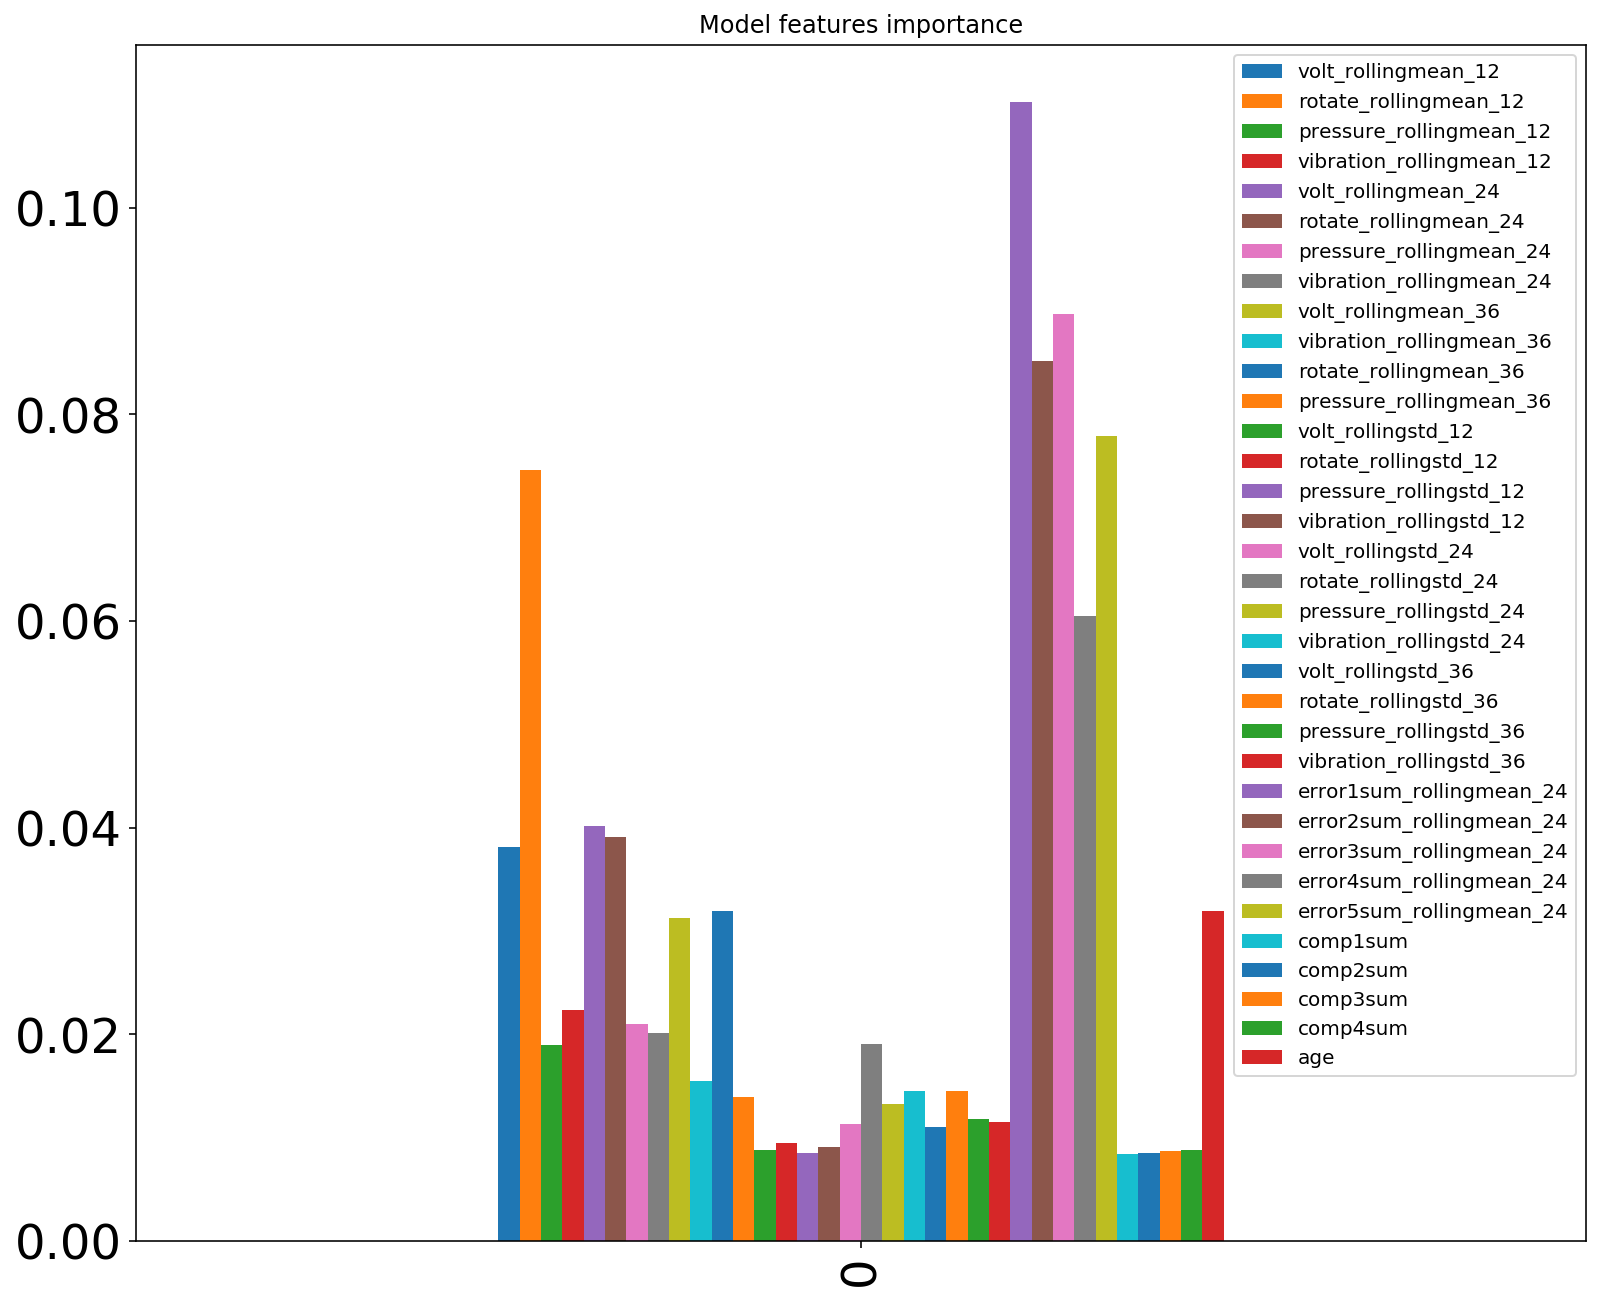

In [43]:
importances = model_pipeline.stages[2].featureImportances


rf = model_pipeline.stages[2]
df = pd.DataFrame.from_dict(importances.values).transpose()
df.columns = input_features

df.plot(kind='bar', figsize =(13,11),
        xlim = (0, max(importances.values)),
             title = "Model features importance",\
             fontsize = 24)

Remember that this is a simulated data set. We would expect a model built on real world data to behave very differently. The accuracy may still be close to one, but the precision and recall numbers would be much lower.

## Persist the model

We'll save the latest model for use in deploying a webservice for operationalization in the next notebook. We store this local to the Jupyter notebook kernel because the model is stored in a hierarchical format that does not translate to Azure Blob storage well. 

In [ ]:
# save model
model_pipeline.write().overwrite().save(os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']+'pdmrfull.model')
print("Model saved")

# Time the notebook execution. 
# This will only make sense if you "Run All" cells
toc = time.time()
print("Full run took %.2f minutes" % ((toc - tic)/60))
logger.log("Model Building Run time", ((toc - tic)/60))

## Conclusion

In the next notebook `Code\4_operationalization.ipynb` Jupyter notebook we will create the functions needed to operationalize and deploy any model to get realtime predictions. 
